# Predict Unlabeled with LSTM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Conv2D, Flatten, Reshape, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.layers import Bidirectional

In [184]:
import data_processing
import feature_extraction

In [185]:
df = data_processing.read_all_users('geolife_trajectories')
df = data_processing.process_classes(df)
df = data_processing.drop_unlabelled(df)

[1/182] processing user 135
[2/182] processing user 132
[3/182] processing user 104
[4/182] processing user 103
[5/182] processing user 168
[6/182] processing user 157
[7/182] processing user 150
[8/182] processing user 159
[9/182] processing user 166
[10/182] processing user 161
[11/182] processing user 102
[12/182] processing user 105
[13/182] processing user 133
[14/182] processing user 134
[15/182] processing user 160
[16/182] processing user 158
[17/182] processing user 167
[18/182] processing user 151
[19/182] processing user 169
[20/182] processing user 156
[21/182] processing user 024
[22/182] processing user 023
[23/182] processing user 015
[24/182] processing user 012
[25/182] processing user 079
[26/182] processing user 046
[27/182] processing user 041
[28/182] processing user 048
[29/182] processing user 077
[30/182] processing user 083
[31/182] processing user 084
[32/182] processing user 070
[33/182] processing user 013
[34/182] processing user 014
[35/182] processing use

In [186]:
df = data_processing.create_segments(df)
df = data_processing.calculations(df)
df = data_processing.filter(df)

In [187]:
updated_df = pd.read_pickle("updated_df_fifteen.pkl")

In [188]:
updated_df

,lat,lon,alt,elapsed time,time,trajectory,label,user,segment,index,...,speed,time_diff,acceleration,jerk,bearing,heading_change,Vrate,angular_velocity,angular_acceleration,new_segment
0,39.974426,116.399735,491.0,39816.056782,2009-01-03 01:21:46,20090103012134.plt,0,135,1.0,7,...,5.026005,4.0,-0.330732,3.316419,314.179106,102.698082,0.263217,25.674520,5.530613,1
1,39.974458,116.399700,491.0,39816.056840,2009-01-03 01:21:51,20090103012134.plt,0,135,1.0,8,...,3.342841,5.0,-0.336633,-0.001180,320.031126,5.852020,0.503513,1.170404,-4.900823,1
2,39.974491,116.399732,490.0,39816.056898,2009-01-03 01:21:56,20090103012134.plt,0,135,1.0,9,...,3.291597,5.0,-0.010249,0.065277,36.616347,76.585221,0.015568,15.317044,2.829328,1
3,39.974530,116.399758,489.0,39816.056956,2009-01-03 01:22:01,20090103012134.plt,0,135,1.0,10,...,3.506231,5.0,0.042927,0.010635,27.061885,9.554462,0.061215,1.910892,-2.681230,1
4,39.974577,116.399745,490.0,39816.056991,2009-01-03 01:22:04,20090103012134.plt,0,135,1.0,11,...,6.410728,3.0,0.968166,0.308413,348.032515,39.029370,0.453068,13.009790,3.699632,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13478904,44.633498,129.063237,1191.0,39299.336343,2007-08-05 08:04:20,20070805070503.plt,0,10,24149.6,14999996,...,91.844368,1.0,0.650083,0.365922,330.656356,2.912336,0.007078,2.912336,2.251269,201111
13478905,44.633918,129.062910,1191.0,39299.336366,2007-08-05 08:04:22,20070805070503.plt,0,10,24149.6,14999997,...,96.103285,2.0,2.129458,0.739688,331.011846,0.355490,0.044316,0.177745,-1.367295,201111
13478906,44.634127,129.062783,1191.0,39299.336377,2007-08-05 08:04:23,20070805070503.plt,0,10,24149.6,14999998,...,91.149788,1.0,-4.953497,-7.082955,336.615756,5.603910,0.054345,5.603910,5.426165,201111
13478907,44.634515,129.062502,1191.0,39299.336400,2007-08-05 08:04:25,20070805070503.plt,0,10,24149.6,14999999,...,87.364980,2.0,-1.892404,1.530547,332.735166,3.880590,0.043322,1.940295,-1.831807,201111


In [5]:
updated_df.iloc[1_000_000:1_030_000].to_csv('HIERGUCKEN.csv', index=False)

In [189]:
time_series_features = ['speed', 'acceleration','jerk','heading_change','angular_velocity', 'angular_acceleration']

Filter extreme values from the unlabeled dataset

In [ ]:
def filter_by_max_values(df, updated_df, columns_to_filter):
    #Filter by the max values of the labeled dataset
    if not columns_to_filter:
        print("Warning: No columns specified for filtering. Returning original updated_df.")
        return updated_df.copy() # Return a copy to maintain consistency

    missing_in_df = [col for col in columns_to_filter if col not in df.columns]
    missing_in_updated_df = [col for col in columns_to_filter if col not in updated_df.columns]

    if missing_in_df:
        raise KeyError(f"Columns not found in the source DataFrame 'df': {missing_in_df}")
    if missing_in_updated_df:
        raise KeyError(f"Columns not found in the target DataFrame 'updated_df': {missing_in_updated_df}")

    max_values = df[columns_to_filter].max()
    print(f"Maximum values calculated from 'df':\n{max_values}\n")

    keep_mask = pd.Series(True, index=updated_df.index)

    for col in columns_to_filter:
        condition = updated_df[col] <= max_values[col]
        keep_mask &= condition


    # Apply the combined mask to filter the DataFrame
    filtered_df = updated_df[keep_mask].copy() # Use copy to avoid SettingWithCopyWarning

    print(f"Original size of 'updated_df': {len(updated_df)} rows")
    print(f"Size after filtering: {len(filtered_df)} rows")

    return filtered_df

# Define the columns to check
time_series_features = ['speed', 'acceleration','jerk','heading_change','angular_velocity', 'angular_acceleration']

# Run the function
updated_df = filter_by_max_values(df, updated_df, time_series_features)

print("\nOriginal updated_df:")
print(updated_df)
print("\nFiltered updated_df:")
print(updated_df)

Maximum values calculated from 'df':
speed                   293.306072
acceleration            221.520460
jerk                    997.383058
heading_change          180.000000
angular_velocity        180.000000
angular_acceleration    180.000000
dtype: float64

Original size of 'updated_df': 13434406 rows
Size after filtering: 13434308 rows

Original updated_df:
                lat         lon     alt  elapsed time                time  \
0         39.974426  116.399735   491.0  39816.056782 2009-01-03 01:21:46   
1         39.974458  116.399700   491.0  39816.056840 2009-01-03 01:21:51   
2         39.974491  116.399732   490.0  39816.056898 2009-01-03 01:21:56   
3         39.974530  116.399758   489.0  39816.056956 2009-01-03 01:22:01   
4         39.974577  116.399745   490.0  39816.056991 2009-01-03 01:22:04   
...             ...         ...     ...           ...                 ...   
13478904  44.633498  129.063237  1191.0  39299.336343 2007-08-05 08:04:20   
13478905  44.63391

In [191]:
columns = ['speed', 'acceleration','jerk','heading_change','angular_velocity', 'angular_acceleration']

global_mins = {}
global_maxs = {}

for col in columns:
    # Get min/max from both datasets
    min1 = df[col].min()
    max1 = df[col].max()
    min2 = updated_df[col].min()
    max2 = updated_df[col].max()
    
    # Compute global values
    global_mins[col] = min(min1, min2)
    global_maxs[col] = max(max1, max2)

print("Global Minimums:", global_mins)
print("Global Maximums:", global_maxs)

Global Minimums: {'speed': 0.00022085781252921755, 'acceleration': -1878.88247646102, 'jerk': -2846.625663814707, 'heading_change': 0.0, 'angular_velocity': 0.0, 'angular_acceleration': -180.0}
Global Maximums: {'speed': 293.3060715168033, 'acceleration': 221.52045997856825, 'jerk': 997.3830575169399, 'heading_change': 180.0, 'angular_velocity': 180.0, 'angular_acceleration': 180.0}


In [ ]:
def normalize_features(df, global_mins, global_maxs):
    """
    Normalize features using global min/max
    """
    normalized_df = df.copy()
    for feature in ['speed', 'acceleration','jerk','heading_change','angular_velocity', 'angular_acceleration']:  
        min_val = global_mins[feature]
        max_val = global_maxs[feature]
        
        # Avoid division by zero (use epsilon if max == min)
        denominator = max_val - min_val
        if denominator == 0:
            denominator = 1  # Or use a small epsilon (e.g., 1e-8)
        
        normalized_df[feature] = (df[feature] - min_val) / denominator
    
    return normalized_df

# Normalize both datasets
df = normalize_features(df, global_mins, global_maxs)
updated_df = normalize_features(updated_df, global_mins, global_maxs)

print("Normalized Dataset 1:")
print(df)
print("\nNormalized Dataset 2:")
print(updated_df)

Normalized Dataset 1:
               lat         lon         alt  elapsed time                time  \
0        39.976200  116.330383  229.658793  39184.432917 2007-04-12 10:23:24   
1        39.976033  116.330367  259.186352  39184.434132 2007-04-12 10:25:09   
2        39.975817  116.330300  275.590551  39184.434398 2007-04-12 10:25:32   
3        39.975700  116.330333  295.275591  39184.435613 2007-04-12 10:27:17   
4        39.975383  116.330667  137.795276  39184.611030 2007-04-12 14:39:53   
...            ...         ...         ...           ...                 ...   
4166298  39.991613  116.330468    0.000000  40908.637292 2011-12-31 15:17:42   
4166299  39.991615  116.330483    0.000000  40908.637350 2011-12-31 15:17:47   
4166300  39.991630  116.330473    0.000000  40908.637407 2011-12-31 15:17:52   
4166301  39.991642  116.330465    0.000000  40908.637465 2011-12-31 15:17:57   
4166302  39.991670  116.330468    0.000000  40908.637523 2011-12-31 15:18:02   

                 

In [192]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [205]:
X_sequences = []
y_sequences = []

for _, group in df.groupby('segment'):
    X_sequences.append(group[time_series_features].values)  # Raw sequences
    y_sequences.append(group['label'].iloc[0])  # Assign one label per segment

In [206]:
# Convert labels to one-hot encoding
y_sequences = to_categorical(y_sequences)
y_sequences

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=19)

In [208]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=19)

In [209]:
def create_rolling_windows(X_sequences, y_sequences, window_size=200, step=100):
    """
    Creates rolling window segments from time-series data, padding short sequences at the beginning.
    
    Parameters:
    - X_sequences: List of time-series feature sequences (NumPy arrays)
    - y_sequences: List of corresponding labels.
    - window_size: Number of time steps per window
    - step: Step size between windows (e.g., 10 for overlap)
    
    Returns:
    - X_windows: NumPy array of rolling window samples
    - y_windows: NumPy array of labels
    """
    X_windows = []
    y_windows = []

    for i in range(len(X_sequences)):  # Loop through sequences
        seq = X_sequences[i]  # Extract single trajectory
        label = y_sequences[i]  # Corresponding label

        # If sequence is shorter than window_size, pad at the beginning
        if len(seq) < window_size:
            pad_length = window_size - len(seq)
            pad = np.zeros((pad_length, seq.shape[1]))  # Create zero padding
            seq = np.vstack((seq, pad))  # Stack padding **after** existing data

            # Add the single padded sequence
            X_windows.append(seq)
            y_windows.append(label)
            continue  # Skip rolling window logic for this sequence

        # Create rolling windows within the sequence
        for j in range(0, len(seq) - window_size + 1, step):
            X_windows.append(seq[j:j + window_size])  # Extract window
            y_windows.append(label)  # Use the same label for entire window

    return np.array(X_windows), np.array(y_windows)

In [210]:
window_size = 200
step_size = 100

In [211]:
# Create rolling windows
X_train2, y_train2 = create_rolling_windows(X_train2, y_train2, window_size, step_size)

# Verify shape
print("Shape of X_train:", X_train2.shape)
print("Shape of y_train:", y_train2.shape)

Shape of X_train: (25094, 200, 6)
Shape of y_train: (25094, 5)


In [212]:
X_test, y_test = create_rolling_windows(X_test, y_test, window_size, step_size)

# Verify shape
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (7504, 200, 6)
Shape of y_test: (7504, 5)


In [213]:
# Create rolling windows
X_val, y_val = create_rolling_windows(X_val, y_val, window_size, step_size)

# Verify shape
print("Shape of X_val", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_val (2669, 200, 6)
Shape of y_val: (2669, 5)


In [ ]:
class_counts = None # Initialize

if isinstance(y_train, np.ndarray) and y_train.ndim == 2:

    decoded_labels = np.argmax(y_train2, axis=1)
    print(f"Decoded class labels: {decoded_labels}") 

    label_series = pd.Series(decoded_labels)
    class_counts = label_series.value_counts().sort_index() 

    print("\nCounts per class (using Pandas value_counts):")
    print(class_counts)

elif isinstance(y_train, list):
     try:
        print("Attempting to process as a list of lists...")
        decoded_labels = [row.index(1) for row in y_train] # Find index of '1' in each sublist
        print(f"Decoded class labels: {decoded_labels}")

        label_series = pd.Series(decoded_labels)
        class_counts = label_series.value_counts().sort_index()
        print("\nCounts per class (using Pandas value_counts):")
        print(class_counts)

     except ValueError:
         print("Error: Could not find index of '1' in every row. Check if input is valid one-hot encoded list of lists.")
     except Exception as e:
         print(f"An error occurred processing the list: {e}")
else:
    print(f"Error: Expected y_train to be a 2D NumPy array or list of lists for OHE decoding, but got {type(y_train)}.")


# Display final summary if counts were calculated
if class_counts is not None:
    print("\n--- Summary ---")
    if isinstance(class_counts, pd.Series):
         for class_label, count in class_counts.items():
              print(f"Class {class_label}: {count} occurrences")

Decoded class labels: [0 0 0 ... 4 4 4]

Counts per class (using Pandas value_counts):
0    3581
1    6340
2    3930
3    4611
4    6632
Name: count, dtype: int64

--- Summary ---
Class 0: 3581 occurrences
Class 1: 6340 occurrences
Class 2: 3930 occurrences
Class 3: 4611 occurrences
Class 4: 6632 occurrences


In [238]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # Use Conv1D for time-series feature extraction
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # LSTM Layers
    model.add(LSTM(128, return_sequences=True))  # Retain temporal dimension
    model.add(Dropout(0.3))
    
    model.add(LSTM(64))  # Final LSTM layer returns output (no sequence)
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [239]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model = create_lstm_model(input_shape, num_classes)

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 198, 32)        │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 198, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 198, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,853 (542.39 KB)

 Trainable params: 138,853 (542.39 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50


KeyboardInterrupt: 

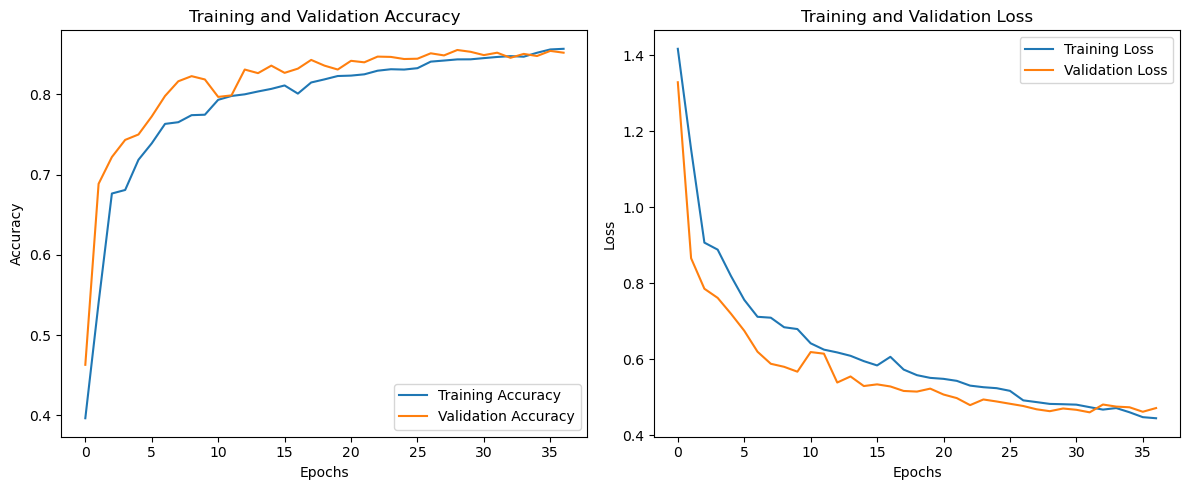

235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.912     0.867     0.889      1022
         bus      0.870     0.754     0.808      1818
         car      0.697     0.758     0.726      1026
       train      0.961     0.913     0.937      1838
        walk      0.852     0.991     0.916      1800

    accuracy                          0.866      7504
   macro avg      0.858     0.857     0.855      7504
weighted avg      0.870     0.866     0.865      7504



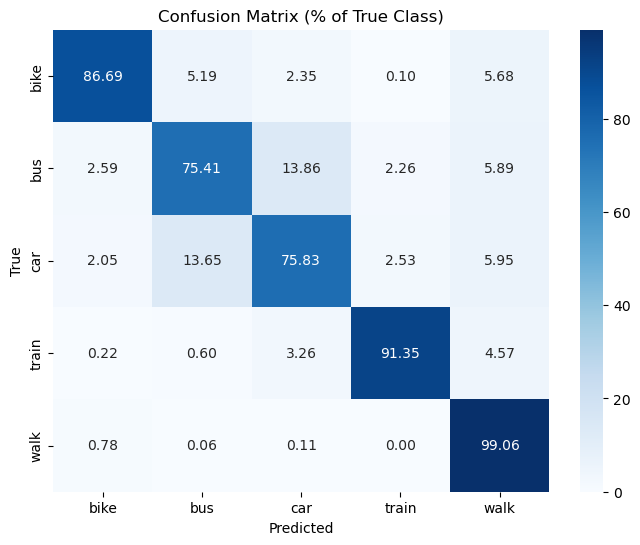

In [24]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_,digits=3  # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

Save this model

In [32]:
# Save the model to a file
model.save('convlstm6filtered.keras')

In [194]:
model = tf.keras.models.load_model('convlstm6filtered.keras')

# Predict

In [ ]:
unique_unlabeled_segments = updated_df['new_segment'].unique()
initial_count = len(unique_unlabeled_segments)
print(f"Initial count of unique segments found in updated_df: {initial_count}")


X_unlabelled_sequences = []
unlabeled_segment_order_tracker = []
skipped_empty_segments = [] # Track skipped segments
skipped_empty_count = 0

print("Generating unlabeled sequences and checking for empty groups...")
for segment_id in unique_unlabeled_segments:
    group = updated_df[updated_df['new_segment'] == segment_id]
    if not group.empty:

        X_unlabelled_sequences.append(group[time_series_features].values)
        unlabeled_segment_order_tracker.append(segment_id)
    else:
        skipped_empty_segments.append(segment_id)
        skipped_empty_count += 1

print(f"Finished sequence generation.")
print(f"   Total unique segments initially: {initial_count}")
print(f"   Segments skipped (e.g., empty): {skipped_empty_count}")
if skipped_empty_count > 0:
     print(f"   Example skipped segment IDs: {skipped_empty_segments[:10]}") # Print first few
print(f"   Sequences generated (X_unlabelled_sequences length): {len(X_unlabelled_sequences)}")
print(f"   Segments tracked (tracker length): {len(unlabeled_segment_order_tracker)}")

Initial count of unique segments found in updated_df: 199697
Generating unlabeled sequences and checking for empty groups...
Finished sequence generation.
   Total unique segments initially: 199697
   Segments skipped (e.g., empty): 0
   Sequences generated (X_unlabelled_sequences length): 199697
   Segments tracked (tracker length): 199697


In [177]:
updated_df['new_segment'].nunique()

199698

In [196]:
len(X_unlabelled_sequences)

199697

Padding

In [ ]:
import numpy as np

def create_padded_windows_max_len(X_sequences, target_length=200):
    """
    Ensures all sequences are exactly target_length.
    Pads shorter sequences at the beginning.
    Truncates longer sequences, keeping the beginning portion.

    Parameters:
    - X_sequences: List of time-series feature sequences (NumPy arrays).
    - target_length: The desired output length for all sequences.

    Returns:
    - X_windows: NumPy array of sequences, all adjusted to target_length.

    """
    X_windows = []
    num_features = 0 # Initialize num_features

    # Determine num_features from the first valid sequence
    for seq in X_sequences:
        if seq is not None and len(seq) > 0:
            if seq.ndim == 1:
                num_features = 1
            else:
                num_features = seq.shape[1]
            break # Found features, exit loop
    if num_features == 0 and X_sequences:
         print("Warning: Could not determine number of features. Returning empty array.")
         return np.array([])



    print(f"Padding/truncating sequences to target_length={target_length} with num_features={num_features}")

    processed_count = 0
    skipped_count = 0 

    for seq in X_sequences:
        if seq is None or seq.size == 0:
             print(f"Warning: Skipping None or empty sequence.")
             skipped_count += 1
             continue

        current_num_features = 1 if seq.ndim == 1 else seq.shape[1]
        if num_features > 0 and current_num_features != num_features:
            print(f"Warning: Sequence found with {current_num_features} features, expected {num_features}. Skipping.")
            skipped_count += 1
            continue
        elif num_features == 0: 
            print(f"Warning: num_features not determined, cannot process sequence. Skipping.")
            skipped_count += 1
            continue

        if seq.ndim == 1:
            seq = seq.reshape(-1, 1) # Reshape to 2D

        seq_len = len(seq) # Use len() which works for list of lists or numpy array first dim

        if seq_len < target_length:
            # Pad sequences shorter than target_length
            pad_length = target_length - seq_len
            pad = np.zeros((pad_length, num_features))
            padded_seq = np.vstack((pad, seq))
            X_windows.append(padded_seq)
            processed_count += 1
        elif seq_len == target_length:
            # Keep sequences that are already the target_length
            X_windows.append(seq)
            processed_count += 1
        else: 
            print(f"Info: Sequence length {seq_len} > target_length {target_length}. Truncating (keeping beginning).")
            truncated_seq = seq[:target_length] # Keep the first target_length elements
            X_windows.append(truncated_seq)
            processed_count += 1

    print(f"Finished processing. Processed: {processed_count}, Skipped: {skipped_count}")

    if not X_windows:
        print("Warning: X_windows is empty after processing. Returning empty NumPy array.")
        # Decide return shape: empty array or array with shape (0, num_features) if known
        if num_features > 0:
            return np.empty((0, num_features), dtype=np.float32) # Or appropriate dtype
        else:
            return np.array([])

    # Convert list of numpy arrays to a single numpy array
    try:
        # Ensure all arrays in the list have the same shape[1] before converting
        shapes = [arr.shape for arr in X_windows]
        if len(set(s[1] for s in shapes)) > 1:
             # This shouldn't happen if the feature check worked, but as a safeguard
             raise ValueError(f"Inconsistent number of features found in sequences before final conversion: {set(s[1] for s in shapes)}")
        if len(set(s[0] for s in shapes)) > 1:
             # This indicates padding/truncating failed
              raise ValueError(f"Inconsistent sequence lengths found before final conversion: {set(s[0] for s in shapes)}")

        result_array = np.array(X_windows, dtype=np.float32) # Specify dtype for consistency
        print(f"Final shape of padded/truncated sequences: {result_array.shape}")
        return result_array
    except Exception as e:
        print(f"Error converting list of sequences to NumPy array: {e}")
        raise # Re-raise the exception

window_size = 200 # Or your desired length
X_unlabelled_windows = create_padded_windows_max_len(X_unlabelled_sequences, target_length=window_size)

print(f"Number of sequences after padding/truncating: {len(X_unlabelled_windows)}")


Padding/truncating sequences to target_length=200 with num_features=6
Info: Sequence length 314 > target_length 200. Truncating (keeping beginning).
Info: Sequence length 229 > target_length 200. Truncating (keeping beginning).
Info: Sequence length 261 > target_length 200. Truncating (keeping beginning).
Info: Sequence length 293 > target_length 200. Truncating (keeping beginning).
Info: Sequence length 291 > target_length 200. Truncating (keeping beginning).
Info: Sequence length 216 > target_length 200. Truncating (keeping beginning).
Info: Sequence length 233 > target_length 200. Truncating (keeping beginning).
Info: Sequence length 280 > target_length 200. Truncating (keeping beginning).
Info: Sequence length 223 > target_length 200. Truncating (keeping beginning).
Info: Sequence length 226 > target_length 200. Truncating (keeping beginning).
Info: Sequence length 276 > target_length 200. Truncating (keeping beginning).
Info: Sequence length 248 > target_length 200. Truncating (ke

In [ ]:
len(X_unlabelled_windows)

432829

In [22]:
time_series_features = ['speed', 'acceleration', 'angular_acceleration']

In [37]:
model2 = load_model('my_trained_model_filtered.keras')

In [198]:
# Make predictions
unlabelled_pred = model.predict(X_unlabelled_windows)

6241/6241 ━━━━━━━━━━━━━━━━━━━━ 275s 44ms/step


In [202]:
len(unlabelled_pred)

199697

In [199]:
y_pred_classes = np.argmax(unlabelled_pred, axis=1)

In [200]:
certainties = np.max(unlabelled_pred, axis=1)

In [201]:
from collections import Counter

# Count the number of occurrences of each unique value in y_pred_classes
unique_counts = Counter(y_pred_classes)

# Display the counts
print("Counts of each unique value in y_pred_classes:")
for label, count in unique_counts.items():
    print(f"{label}: {count}")

Counts of each unique value in y_pred_classes:
3: 48384
4: 36725
2: 97025
1: 11587
0: 5976


Add predictions and certainties to the dataframe

In [ ]:
new_segment_col = 'new_segment' 

print("Starting mapping for unlabeled data...")
print(f"Number of segments tracked: {len(unlabeled_segment_order_tracker)}")
print(f"Number of predictions: {len(y_pred_classes)}")
print(f"Number of certainties: {len(certainties)}")

# Verify Lengths
if not (len(unlabeled_segment_order_tracker) == len(y_pred_classes) == len(certainties)):
    raise ValueError("Length mismatch between segment tracker, predictions, and certainties!")
else:
    print("Lengths match, proceeding with mapping.")

# Create mapping dictionaries
segment_to_prediction_map = dict(zip(unlabeled_segment_order_tracker, y_pred_classes))
segment_to_certainty_map = dict(zip(unlabeled_segment_order_tracker, certainties))

# Map predictions to updated_df
pred_col_name = 'predicted_class_index' # Use a name indicating it's the index first
print(f"Mapping predictions to column '{pred_col_name}'...")
updated_df[pred_col_name] = updated_df[new_segment_col].map(segment_to_prediction_map)

# Map certainties to updated_df
cert_col_name = 'prediction_certainty'
print(f"Mapping certainties to column '{cert_col_name}'...")
updated_df[cert_col_name] = updated_df[new_segment_col].map(segment_to_certainty_map)

if 'label_encoder' in locals():
     try:
         str_pred_col_name = 'predicted_class_label'
         print(f"Applying inverse transform to get string labels in '{str_pred_col_name}'...")
         valid_indices = updated_df[pred_col_name].notna()
         updated_df[str_pred_col_name] = pd.NA # Initialize column with missing values
         if valid_indices.any():
               updated_df.loc[valid_indices, str_pred_col_name] = label_encoder.inverse_transform(updated_df.loc[valid_indices, pred_col_name].astype(int))
         print("Inverse transform applied.")
     except Exception as e:
         print(f"Could not apply label_encoder.inverse_transform: {e}")
         # Keep the index column anyway
         str_pred_col_name = pred_col_name # Fallback to index column name if transform fails
else:
    print("LabelEncoder not found, keeping predicted class as index.")
    str_pred_col_name = pred_col_name # Use the index column name for display

# Verification
print("\nMapping complete for unlabeled data.")
print("Sample of updated_df with mapped predictions and certainties:")

display_cols = [new_segment_col]
# Add index if it's named or meaningful
if updated_df.index.name:
     display_cols.append(updated_df.index.name)
display_cols.extend([str_pred_col_name, cert_col_name]) # Show string label (or index) and certainty
display_cols = list(dict.fromkeys(display_cols)) # Keep unique

print(updated_df[display_cols].head(10))
print("...")
print(updated_df[display_cols].tail(10))

# Check value counts and certainty ranges
print(f"\nValue counts for '{str_pred_col_name}':")
print(updated_df[str_pred_col_name].value_counts(dropna=False)) # Include NaNs if any
print(f"\nCertainty ({cert_col_name}) summary:")
print(updated_df[cert_col_name].describe())

nan_pred_count = updated_df[pred_col_name].isna().sum()
nan_cert_count = updated_df[cert_col_name].isna().sum()
if nan_pred_count > 0 or nan_cert_count > 0:
     print(f"\nWarning: Found {nan_pred_count} missing predictions and {nan_cert_count} missing certainties after mapping.")

Starting mapping for unlabeled data...
Number of segments tracked: 199697
Number of predictions: 199697
Number of certainties: 199697
Lengths match, proceeding with mapping.
Mapping predictions to column 'predicted_class_index'...
Mapping certainties to column 'prediction_certainty'...
Applying inverse transform to get string labels in 'predicted_class_label'...
Inverse transform applied.

Mapping complete for unlabeled data.
Sample of updated_df with mapped predictions and certainties:
   new_segment predicted_class_label  prediction_certainty
0            1                 train              0.750285
1            1                 train              0.750285
2            1                 train              0.750285
3            1                 train              0.750285
4            1                 train              0.750285
5            1                 train              0.750285
6            1                 train              0.750285
7            1                 train

In [34]:
updated_df

,lat,lon,alt,elapsed time,time,trajectory,label,user,segment,index,...,jerk,bearing,heading_change,Vrate,angular_velocity,angular_acceleration,new_segment,predicted_class_index,prediction_certainty,predicted_class_label
0,39.974426,116.399735,491.0,39816.056782,2009-01-03 01:21:46,20090103012134.plt,0,135,1.0,7,...,0.741398,314.179106,0.570545,0.263217,0.142636,0.515363,1,3,0.750285,train
1,39.974458,116.399700,491.0,39816.056840,2009-01-03 01:21:51,20090103012134.plt,0,135,1.0,8,...,0.740535,320.031126,0.032511,0.503513,0.006502,0.486387,1,3,0.750285,train
2,39.974491,116.399732,490.0,39816.056898,2009-01-03 01:21:56,20090103012134.plt,0,135,1.0,9,...,0.740553,36.616347,0.425473,0.015568,0.085095,0.507859,1,3,0.750285,train
3,39.974530,116.399758,489.0,39816.056956,2009-01-03 01:22:01,20090103012134.plt,0,135,1.0,10,...,0.740538,27.061885,0.053080,0.061215,0.010616,0.492552,1,3,0.750285,train
4,39.974577,116.399745,490.0,39816.056991,2009-01-03 01:22:04,20090103012134.plt,0,135,1.0,11,...,0.740616,348.032515,0.216830,0.453068,0.072277,0.510277,1,3,0.750285,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13478904,44.633498,129.063237,1191.0,39299.336343,2007-08-05 08:04:20,20070805070503.plt,0,10,24149.6,14999996,...,0.740631,330.656356,0.016180,0.007078,0.016180,0.506254,201111,3,0.990445,train
13478905,44.633918,129.062910,1191.0,39299.336366,2007-08-05 08:04:22,20070805070503.plt,0,10,24149.6,14999997,...,0.740728,331.011846,0.001975,0.044316,0.000987,0.496202,201111,3,0.990445,train
13478906,44.634127,129.062783,1191.0,39299.336377,2007-08-05 08:04:23,20070805070503.plt,0,10,24149.6,14999998,...,0.738693,336.615756,0.031133,0.054345,0.031133,0.515073,201111,3,0.990445,train
13478907,44.634515,129.062502,1191.0,39299.336400,2007-08-05 08:04:25,20070805070503.plt,0,10,24149.6,14999999,...,0.740934,332.735166,0.021559,0.043322,0.010779,0.494912,201111,3,0.990445,train


In [ ]:
updated_df['label2'] = label_encoder.inverse_transform(updated_df['label'])

In [ ]:
updated_df.to_pickle("updated_df_fifteen_predicted.pkl")

NameError: name 'updated_df' is not defined

In [204]:
updated_df = pd.read_pickle("updated_df_fifteen_predicted.pkl")

In [12]:
updated_df

,lat,lon,alt,elapsed time,time,trajectory,label,user,segment,index,...,bearing,heading_change,Vrate,angular_velocity,angular_acceleration,new_segment,predicted_class_index,prediction_certainty,predicted_class_label,label2
0,39.974426,116.399735,491.000000,39816.056782,2009-01-03 01:21:46,20090103012134.plt,0,135,1.0,7,...,314.179106,0.570545,0.263217,0.142636,0.515363,1,2,0.826422,car,bike
1,39.974458,116.399700,491.000000,39816.056840,2009-01-03 01:21:51,20090103012134.plt,0,135,1.0,8,...,320.031126,0.032511,0.503513,0.006502,0.486387,1,2,0.826422,car,bike
2,39.974491,116.399732,490.000000,39816.056898,2009-01-03 01:21:56,20090103012134.plt,0,135,1.0,9,...,36.616347,0.425473,0.015568,0.085095,0.507859,1,2,0.826422,car,bike
3,39.974530,116.399758,489.000000,39816.056956,2009-01-03 01:22:01,20090103012134.plt,0,135,1.0,10,...,27.061885,0.053080,0.061215,0.010616,0.492552,1,2,0.826422,car,bike
4,39.974577,116.399745,490.000000,39816.056991,2009-01-03 01:22:04,20090103012134.plt,0,135,1.0,11,...,348.032515,0.216830,0.453068,0.072277,0.510277,1,2,0.826422,car,bike
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16872068,39.973817,116.324117,265.748031,39286.418252,2007-07-23 10:02:17,20070723033153.plt,0,171,32069.0,19449857,...,178.004991,0.009795,0.400235,0.000084,0.499966,434892,3,0.850822,train,bike
16872069,39.973333,116.323683,265.748031,39286.419028,2007-07-23 10:03:24,20070723033153.plt,0,171,32069.0,19449858,...,214.491703,0.202704,0.084086,0.003025,0.500022,434892,3,0.850822,train,bike
16872070,39.973733,116.323250,364.173228,39286.419421,2007-07-23 10:03:58,20070723033153.plt,0,171,32069.0,19449859,...,320.300578,0.587827,0.427589,0.017289,0.500210,434892,3,0.850822,train,bike
16872071,39.973317,116.322967,246.062992,39286.420243,2007-07-23 10:05:09,20070723033153.plt,0,171,32069.0,19449860,...,207.524658,0.626533,1.310617,0.008824,0.499940,434892,3,0.850822,train,bike


In [ ]:
def filter_entire_trajectories(
    df: pd.DataFrame,
    max_speed_kmh: float = 0.6,
    max_distance_km: float = 0.2,
    segment_col: str = 'new_segment'
) -> pd.DataFrame:
    """
    Remove entire trajectories where ANY point exceeds specified thresholds for plotting

    - df: DataFrame containing trajectory data with:
        - 'speed' (in km/s - ensure this matches your calculation units)
        - 'distance' (in km between consecutive points)
    - max_speed_kmh: Maximum allowed speed in km/h (converted to km/s internally)
    - max_distance_km: Maximum allowed distance between consecutive points in km
    - segment_col: Column name identifying unique trajectories

    Returns:
    - DataFrame containing only complete trajectories where ALL points:
        - Speed ≤ max_speed_kmh 
        - Distance ≤ max_distance_km

    """
    if 'speed' not in df.columns or 'distance' not in df.columns:
        raise ValueError("DataFrame must contain 'speed' and 'distance' columns")
    
    if segment_col not in df.columns:
        raise ValueError(f"Segment column '{segment_col}' not found in DataFrame")

    # Convert speed threshold from km/h to km/s
    threshold_km_per_sec = max_speed_kmh 

    # Identify segments with any violations
    violation_mask = (
        (df['speed'] > threshold_km_per_sec) |
        (df['distance'] > max_distance_km)
    )
    
    # Get list of bad segments with ANY violations
    bad_segments = df.loc[violation_mask, segment_col].unique()
    
    # Filter out all points from bad segments
    clean_df = df[~df[segment_col].isin(bad_segments)].copy()
    
    return clean_df.reset_index(drop=True)

In [12]:
updated_df

,lat,lon,alt,elapsed time,time,trajectory,label,user,segment,index,...,jerk,bearing,heading_change,Vrate,angular_velocity,angular_acceleration,new_segment,predicted_class_index,prediction_certainty,predicted_class_label
0,39.974426,116.399735,491.0,39816.056782,2009-01-03 01:21:46,20090103012134.plt,0,135,1.0,7,...,0.741398,314.179106,0.570545,0.263217,0.142636,0.515363,1,3,0.750285,train
1,39.974458,116.399700,491.0,39816.056840,2009-01-03 01:21:51,20090103012134.plt,0,135,1.0,8,...,0.740535,320.031126,0.032511,0.503513,0.006502,0.486387,1,3,0.750285,train
2,39.974491,116.399732,490.0,39816.056898,2009-01-03 01:21:56,20090103012134.plt,0,135,1.0,9,...,0.740553,36.616347,0.425473,0.015568,0.085095,0.507859,1,3,0.750285,train
3,39.974530,116.399758,489.0,39816.056956,2009-01-03 01:22:01,20090103012134.plt,0,135,1.0,10,...,0.740538,27.061885,0.053080,0.061215,0.010616,0.492552,1,3,0.750285,train
4,39.974577,116.399745,490.0,39816.056991,2009-01-03 01:22:04,20090103012134.plt,0,135,1.0,11,...,0.740616,348.032515,0.216830,0.453068,0.072277,0.510277,1,3,0.750285,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13478904,44.633498,129.063237,1191.0,39299.336343,2007-08-05 08:04:20,20070805070503.plt,0,10,24149.6,14999996,...,0.740631,330.656356,0.016180,0.007078,0.016180,0.506254,201111,3,0.990445,train
13478905,44.633918,129.062910,1191.0,39299.336366,2007-08-05 08:04:22,20070805070503.plt,0,10,24149.6,14999997,...,0.740728,331.011846,0.001975,0.044316,0.000987,0.496202,201111,3,0.990445,train
13478906,44.634127,129.062783,1191.0,39299.336377,2007-08-05 08:04:23,20070805070503.plt,0,10,24149.6,14999998,...,0.738693,336.615756,0.031133,0.054345,0.031133,0.515073,201111,3,0.990445,train
13478907,44.634515,129.062502,1191.0,39299.336400,2007-08-05 08:04:25,20070805070503.plt,0,10,24149.6,14999999,...,0.740934,332.735166,0.021559,0.043322,0.010779,0.494912,201111,3,0.990445,train


In [13]:
updated_df2 = filter_entire_trajectories(updated_df)

In [14]:
segment = updated_df2.groupby('new_segment')

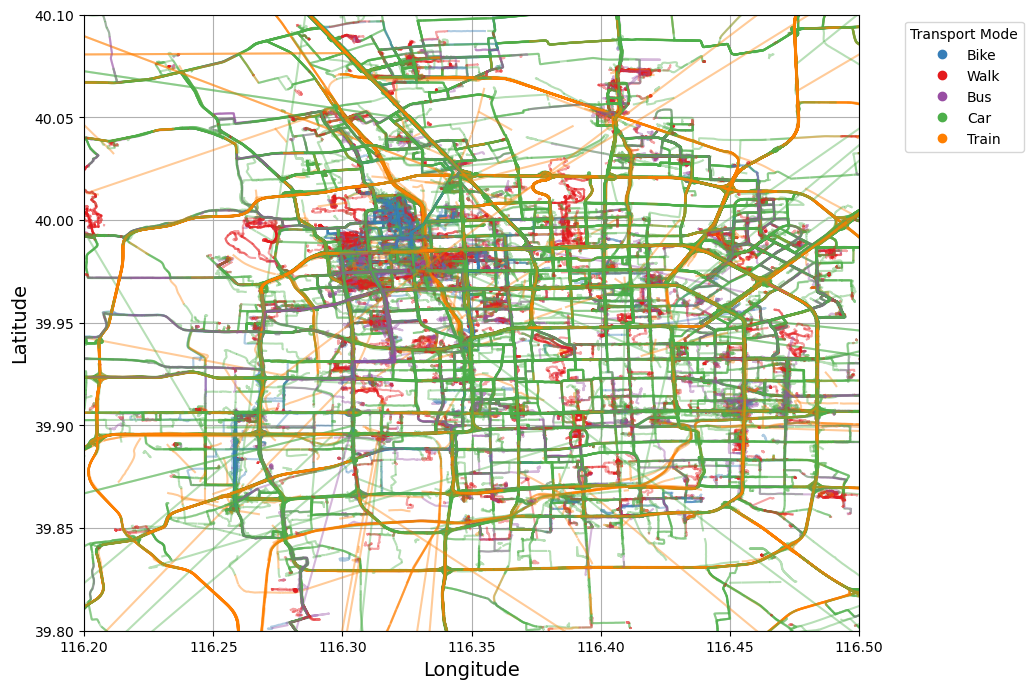

In [ ]:
color_palette = sns.color_palette("Set1", 8)

# Assign transport modes to colors
color_map = {
    'walk': color_palette[0],   # Soft Green
    'bike': color_palette[1],   # Light Orange
    'car': color_palette[2],    # Light Blue
    'bus': color_palette[3],    # Light Purple
    'train': color_palette[4],  # Teal
    '0': color_palette[5]         # Default for missing labels
}
plt.figure(figsize=(10, 8))
#plt.title("Geolife Trajectories by Transport Mode", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.xlim(116.2, 116.5)  # Longitude limits
plt.ylim(39.8, 40.1)  # Latitude limits

# Track unique transport modes for legend
unique_labels = set()

# Iterate over each segment and plot it with the corresponding color
for name, group in segment:
    transport_mode = group['predicted_class_label'].iloc[0]  # Take the first label for the segment
    color = color_map.get(transport_mode, 'black')  # Default to black if label is unknown
    plt.plot(group['lon'], group['lat'],color=color, alpha=0.4)
    unique_labels.add(transport_mode)  # Collect unique transport modes for legend

# Create a custom legend with label replacements
handles = []
labels = []
for label in unique_labels:
    # Replace '0' with "Unlabeled" in legend
    display_label = "Unlabeled" if str(label) == '0' else str(label).capitalize()
    handles.append(plt.Line2D([0], [0], 
                    color=color_map.get(str(label), 'gray'), 
                    lw=2,
                    marker='o',
                    linestyle='None'))
    labels.append(display_label)

plt.legend(handles, labels, 
           title="Transport Mode", 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left',
           fontsize=10)

#plt.tight_layout()
plt.grid()

# Save the plot
plt.savefig("Graphs/geolife_trajectories_unlabeled_predicted.png", dpi=500, bbox_inches="tight")
#plt.savefig(save_path, dpi=600, format="png", bbox_inches="tight", transparent=True)
# Show the plot
plt.show()

Find a single trajectory

In [ ]:
filtered_df = updated_df[
    (updated_df['lon'].between(116.33, 116.35)) & 
    (updated_df['lat'].between(39.95, 40.25))
].copy().reset_index(drop=True)

In [97]:
filtered_df.head(60000).to_csv('filtered_df.csv', index=False)

In [16]:
new_df = updated_df[updated_df['new_segment']==25896]

In [62]:
new_df

,lat,lon,alt,elapsed time,time,trajectory,label,user,segment,index,...,acceleration,jerk,bearing,heading_change,Vrate,angular_velocity,angular_acceleration,new_segment,certainties,label2
1641160,39.830027,116.366543,167.3,40004.090231,2009-07-10 02:09:56,20090710003114.plt,3,41,2649.11,1846632,...,0.884085,0.003704,268.279107,7.555555e-05,0.007838,7.555555e-05,0.498449,25896,0.951457,train
1641161,39.830020,116.366323,170.6,40004.090243,2009-07-10 02:09:57,20090710003114.plt,3,41,2649.11,1846633,...,0.884327,0.003704,267.729079,3.055710e-03,0.015330,3.055710e-03,0.501490,25896,0.951457,train
1641162,39.830010,116.366100,170.6,40004.090255,2009-07-10 02:09:58,20090710003114.plt,3,41,2649.11,1846634,...,0.884346,0.003703,266.662654,5.924583e-03,0.015676,5.924583e-03,0.501434,25896,0.951457,train
1641163,39.830003,116.365880,170.6,40004.090266,2009-07-10 02:09:59,20090710003114.plt,3,41,2649.11,1846635,...,0.883346,0.003700,267.763956,6.118342e-03,0.015488,6.118342e-03,0.500097,25896,0.951457,train
1641164,39.829993,116.365655,170.6,40004.090278,2009-07-10 02:10:00,20090710003114.plt,3,41,2649.11,1846636,...,0.884578,0.003706,266.687816,5.978558e-03,0.022668,5.978558e-03,0.499930,25896,0.951457,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641257,39.829852,116.345785,167.3,40004.091354,2009-07-10 02:11:33,20090710003114.plt,3,41,2649.11,1846729,...,0.883607,0.003703,270.000061,2.844328e-09,0.008346,2.844328e-09,0.498193,25896,0.951457,train
1641258,39.829857,116.345597,167.3,40004.091366,2009-07-10 02:11:34,20090710003114.plt,3,41,2649.11,1846730,...,0.883363,0.003702,271.980385,1.100180e-02,0.017448,1.100180e-02,0.505501,25896,0.951457,train
1641259,39.829860,116.345408,167.3,40004.091377,2009-07-10 02:11:35,20090710003114.plt,3,41,2649.11,1846731,...,0.883830,0.003704,271.346970,3.518975e-03,0.000321,3.518975e-03,0.496259,25896,0.951457,train
1641260,39.829865,116.345227,167.3,40004.091389,2009-07-10 02:11:36,20090710003114.plt,3,41,2649.11,1846732,...,0.882893,0.003700,272.011246,3.690422e-03,0.035972,3.690422e-03,0.500086,25896,0.951457,train


/var/folders/6q/9kdss80974ldrx7hy_83wyn00000gn/T/ipykernel_1283/3874952607.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['x'], new_df['y'] = transformer.transform(


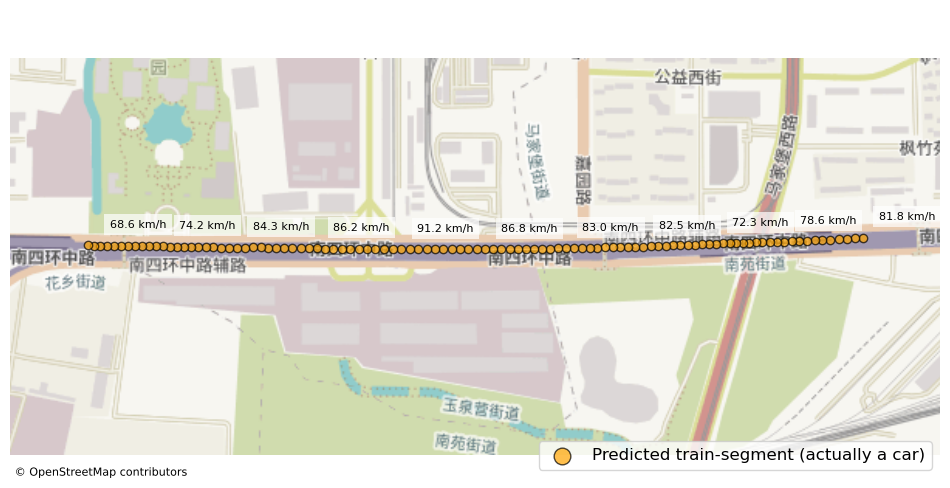

In [ ]:
color_palette = sns.color_palette("Set1", 8)

# Convert coordinates
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
new_df['x'], new_df['y'] = transformer.transform(
    new_df['lon'].values, 
    new_df['lat'].values
)

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

# Assign colors and labels
colors = {25896: 'orange'}
labels = {25896: 'Predicted train-segment (actually a car)'}

for segment, group in new_df.groupby('new_segment'):  
    ax.scatter(
        group['x'], 
        group['y'], 
        color=colors[segment], 
        label=labels[segment],
        alpha=0.7, 
        edgecolor='k',
        zorder=2  # Ensure points appear above basemap
    )

x_offset = 50  
y_offset = 50  
for i in range(0, len(new_df), 10):
    row = new_df.iloc[i]
    label_x = row['x'] + x_offset
    label_y = row['y'] + y_offset

    ax.text(
        label_x,  # Use the offset x-coordinate
        label_y,  # Use the offset y-coordinate
        f"{row['speed']*360:.1f} km/h",
        fontsize=8,

        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
        zorder=3 # Ensure labels are above points
    )

# Add basemap
ctx.add_basemap(
    ax,
    url="https://tile.openstreetmap.org/{z}/{x}/{y}.png",
    attribution="© OpenStreetMap contributors",
    zorder=1  # Place basemap below points
)

# Customize plot bounds
x_min, x_max = new_df['x'].min(), new_df['x'].max()
y_min, y_max = new_df['y'].min(), new_df['y'].max()

x_pad = (x_max - x_min) * 0.1
y_pad = (y_max - y_min) * 20

ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad, y_max + y_pad)

# Final adjustments
ax.set_aspect('equal')
ax.set_axis_off()

plt.legend(
    #title='Trajectory segments',
    loc='lower right',
    fontsize=12,
    title_fontsize=14,
    markerscale=2,
    frameon=True,
    framealpha=0.8
)

plt.savefig("Graphs/single_predicted_trajectory.png", dpi=500, bbox_inches="tight")
plt.show()

Plot a walk-segment

In [22]:
new_df = updated_df[updated_df['new_segment']==92839]

/var/folders/6q/9kdss80974ldrx7hy_83wyn00000gn/T/ipykernel_1283/1048768409.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['x'], new_df['y'] = transformer.transform(
/var/folders/6q/9kdss80974ldrx7hy_83wyn00000gn/T/ipykernel_1283/1048768409.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['x'], new_df['y'] = transformer.transform(


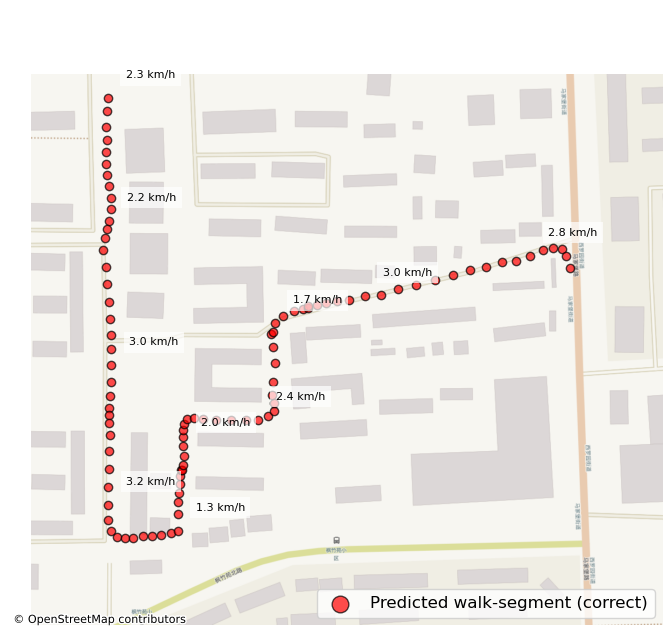

In [ ]:
color_palette = sns.color_palette("Set1", 8)

# Convert coordinates
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
new_df['x'], new_df['y'] = transformer.transform(
    new_df['lon'].values, 
    new_df['lat'].values
)

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

# Assign colors and labels
colors = {92839: 'red'}
labels = {92839: 'Predicted walk-segment (correct)'}

# Plot data - ensure column name matches your DataFrame
for segment, group in new_df.groupby('new_segment'):  # Changed to 'new_segment'
    ax.scatter(
        group['x'], 
        group['y'], 
        color=colors[segment], 
        label=labels[segment],
        alpha=0.7, 
        edgecolor='k',
        zorder=2  # Ensure points appear above basemap
    )

x_offset = 20  
y_offset = 20  
for i in range(0, len(new_df), 10):
    row = new_df.iloc[i]
    label_x = row['x'] + x_offset
    label_y = row['y'] + y_offset

    ax.text(
        label_x,  # Use the offset x-coordinate
        label_y,  # Use the offset y-coordinate
        f"{row['speed']*36:.1f} km/h",
        fontsize=8,

        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
        zorder=3 # Ensure labels are above points if needed
    )

# Add basemap
ctx.add_basemap(
    ax,
    url="https://tile.openstreetmap.org/{z}/{x}/{y}.png",
    attribution="© OpenStreetMap contributors",
    zorder=1  # Place basemap below points
)

# Customize plot bounds
x_min, x_max = new_df['x'].min(), new_df['x'].max()
y_min, y_max = new_df['y'].min(), new_df['y'].max()

x_pad = (x_max - x_min) * 0.2
y_pad = (y_max - y_min) * 0.2

ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad, y_max + y_pad)


# Final adjustments
ax.set_aspect('equal')
ax.set_axis_off()

plt.legend(
    #title='Trajectory segments',
    loc='lower right',
    fontsize=12,
    title_fontsize=14,
    markerscale=2,
    frameon=True,
    framealpha=0.8
)

plt.savefig("Graphs/single_predicted_trajectory2.png", dpi=500, bbox_inches="tight")
plt.show()

In [19]:
new_df = updated_df[updated_df['new_segment']==9089]

/var/folders/6q/9kdss80974ldrx7hy_83wyn00000gn/T/ipykernel_1283/3264128645.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['x'], new_df['y'] = transformer.transform(
/var/folders/6q/9kdss80974ldrx7hy_83wyn00000gn/T/ipykernel_1283/3264128645.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['x'], new_df['y'] = transformer.transform(


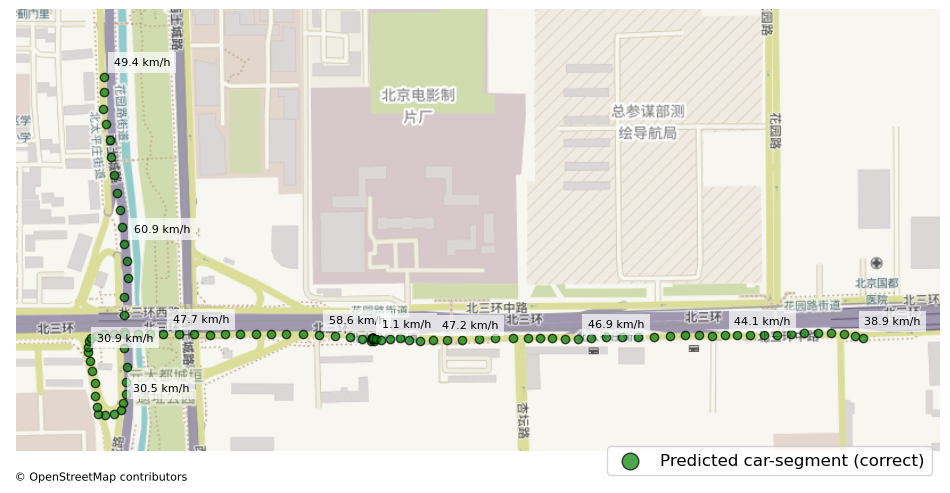

In [ ]:
# Get the Set1 color palette
color_palette = sns.color_palette("Set1", 8)

# Convert coordinates
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
new_df['x'], new_df['y'] = transformer.transform(
    new_df['lon'].values, 
    new_df['lat'].values
)

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

# Assign colors and labels
colors = {9089: 'green'}
labels = {9089: 'Predicted car-segment (correct)'}

for segment, group in new_df.groupby('new_segment'):  
    ax.scatter(
        group['x'], 
        group['y'], 
        color=colors[segment], 
        label=labels[segment],
        alpha=0.7, 
        edgecolor='k',
        zorder=2  # Ensure points appear above basemap
    )

x_offset = 20  
y_offset = 20  
for i in range(0, len(new_df), 10):
    row = new_df.iloc[i]
    label_x = row['x'] + x_offset
    label_y = row['y'] + y_offset

    ax.text(
        label_x,  # Use the offset x-coordinate
        label_y,  # Use the offset y-coordinate
        f"{row['speed']*360:.1f} km/h",
        fontsize=8,
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
        zorder=3 # Ensure labels are above points if needed
    )

# Add basemap
ctx.add_basemap(
    ax,
    url="https://tile.openstreetmap.org/{z}/{x}/{y}.png",
    attribution="© OpenStreetMap contributors",
    zorder=1  # Place basemap below points
)

# Customize plot bounds
x_min, x_max = new_df['x'].min(), new_df['x'].max()
y_min, y_max = new_df['y'].min(), new_df['y'].max()

x_pad = (x_max - x_min) * 0.1
y_pad = (y_max - y_min) * 0.2

ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad, y_max + y_pad)


# Final adjustments
ax.set_aspect('equal')
ax.set_axis_off()

plt.legend(
    #title='Trajectory segments',
    loc='lower right',
    fontsize=12,
    title_fontsize=14,
    markerscale=2,
    frameon=True,
    framealpha=0.8
)

plt.savefig("Graphs/single_predicted_trajectory3.png", dpi=500, bbox_inches="tight")
plt.show()

# Training unlabeled and labeled together

In [6]:
updated_df

,lat,lon,alt,elapsed time,time,trajectory,label,user,segment,index,...,jerk,bearing,heading_change,Vrate,angular_velocity,angular_acceleration,new_segment,predicted_class_index,prediction_certainty,predicted_class_label
0,39.974426,116.399735,491.0,39816.056782,2009-01-03 01:21:46,20090103012134.plt,0,135,1.0,7,...,0.741398,314.179106,0.570545,0.263217,0.142636,0.515363,1,3,0.750285,train
1,39.974458,116.399700,491.0,39816.056840,2009-01-03 01:21:51,20090103012134.plt,0,135,1.0,8,...,0.740535,320.031126,0.032511,0.503513,0.006502,0.486387,1,3,0.750285,train
2,39.974491,116.399732,490.0,39816.056898,2009-01-03 01:21:56,20090103012134.plt,0,135,1.0,9,...,0.740553,36.616347,0.425473,0.015568,0.085095,0.507859,1,3,0.750285,train
3,39.974530,116.399758,489.0,39816.056956,2009-01-03 01:22:01,20090103012134.plt,0,135,1.0,10,...,0.740538,27.061885,0.053080,0.061215,0.010616,0.492552,1,3,0.750285,train
4,39.974577,116.399745,490.0,39816.056991,2009-01-03 01:22:04,20090103012134.plt,0,135,1.0,11,...,0.740616,348.032515,0.216830,0.453068,0.072277,0.510277,1,3,0.750285,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13478904,44.633498,129.063237,1191.0,39299.336343,2007-08-05 08:04:20,20070805070503.plt,0,10,24149.6,14999996,...,0.740631,330.656356,0.016180,0.007078,0.016180,0.506254,201111,3,0.990445,train
13478905,44.633918,129.062910,1191.0,39299.336366,2007-08-05 08:04:22,20070805070503.plt,0,10,24149.6,14999997,...,0.740728,331.011846,0.001975,0.044316,0.000987,0.496202,201111,3,0.990445,train
13478906,44.634127,129.062783,1191.0,39299.336377,2007-08-05 08:04:23,20070805070503.plt,0,10,24149.6,14999998,...,0.738693,336.615756,0.031133,0.054345,0.031133,0.515073,201111,3,0.990445,train
13478907,44.634515,129.062502,1191.0,39299.336400,2007-08-05 08:04:25,20070805070503.plt,0,10,24149.6,14999999,...,0.740934,332.735166,0.021559,0.043322,0.010779,0.494912,201111,3,0.990445,train


In [7]:
updated_df[updated_df['predicted_class_label'] == 'car']

,lat,lon,alt,elapsed time,time,trajectory,label,user,segment,index,...,jerk,bearing,heading_change,Vrate,angular_velocity,angular_acceleration,new_segment,predicted_class_index,prediction_certainty,predicted_class_label
901,39.969369,116.394775,-45.0,39816.081759,2009-01-03 01:57:44,20090103012134.plt,0,135,1.2,584,...,0.740379,349.339633,9.806223e-02,0.302765,3.268741e-02,0.502542,6,2,0.911252,car
902,39.969421,116.394742,-51.0,39816.081782,2009-01-03 01:57:46,20090103012134.plt,0,135,1.2,585,...,0.740887,334.063510,8.486735e-02,0.331293,4.243367e-02,0.502437,6,2,0.911252,car
903,39.969486,116.394710,-56.0,39816.081806,2009-01-03 01:57:48,20090103012134.plt,0,135,1.2,586,...,0.740438,339.328608,2.925054e-02,0.167671,1.462527e-02,0.493048,6,2,0.911252,car
904,39.969554,116.394672,-61.0,39816.081829,2009-01-03 01:57:50,20090103012134.plt,0,135,1.2,587,...,0.740443,336.815787,1.396012e-02,0.060849,6.980058e-03,0.498089,6,2,0.911252,car
905,39.969628,116.394636,-67.0,39816.081852,2009-01-03 01:57:52,20090103012134.plt,0,135,1.2,588,...,0.740542,339.552736,1.520527e-02,0.063337,7.602637e-03,0.500156,6,2,0.911252,car
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13477734,44.587068,129.599215,842.0,39299.302778,2007-08-05 07:16:00,20070805070503.plt,0,10,24149.0,14998772,...,0.742174,256.083138,2.999327e-02,0.082506,2.999327e-02,0.490521,201100,2,0.826020,car
13477735,44.587053,129.599130,842.0,39299.302801,2007-08-05 07:16:02,20070805070503.plt,0,10,24149.0,14998773,...,0.740263,256.083147,5.033266e-08,0.600000,2.516633e-08,0.492502,201100,2,0.826020,car
13477736,44.587012,129.599062,842.0,39299.302836,2007-08-05 07:16:05,20070805070503.plt,0,10,24149.0,14998774,...,0.740744,229.748519,1.463035e-01,0.474306,4.876783e-02,0.508128,201100,2,0.826020,car
13477737,44.586980,129.598935,842.0,39299.302859,2007-08-05 07:16:07,20070805070503.plt,0,10,24149.0,14998775,...,0.741408,250.516457,1.153774e-01,0.559083,5.768872e-02,0.502230,201100,2,0.826020,car


In [163]:
new_df = updated_df[updated_df['new_segment']==7650]

In [164]:
new_df = new_df[29:59]

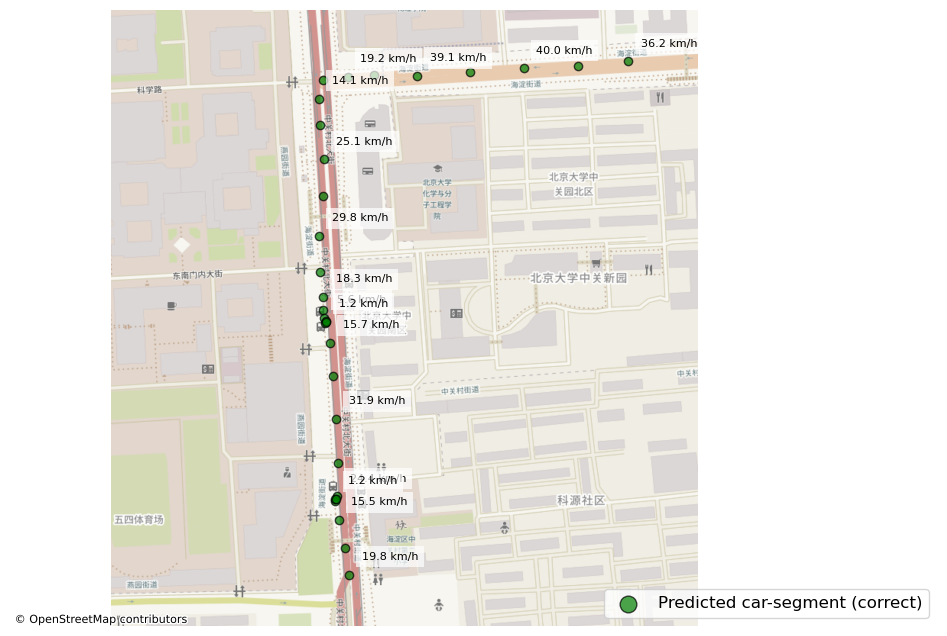

In [ ]:
# Get the Set1 color palette
color_palette = sns.color_palette("Set1", 8)

# Convert coordinates
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
new_df['x'], new_df['y'] = transformer.transform(
    new_df['lon'].values, 
    new_df['lat'].values
)

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

# Assign colors and labels
colors = {7650: 'green'}
labels = {7650: 'Predicted car-segment (correct)'}

for segment, group in new_df.groupby('new_segment'):  
    ax.scatter(
        group['x'], 
        group['y'], 
        color=colors[segment], 
        label=labels[segment],
        alpha=0.7, 
        edgecolor='k',
        zorder=2  # Ensure points appear above basemap
    )

x_offset = 20  # Example: Move label 50 units (meters) to the right
y_offset = 20  # Example: Move label 50 units (meters) up
for i in range(0, len(new_df), 2):
    row = new_df.iloc[i]
    label_x = row['x'] + x_offset
    label_y = row['y'] + y_offset

    ax.text(
        label_x,  # Use the offset x-coordinate
        label_y,  # Use the offset y-coordinate
        f"{row['speed']*250:.1f} km/h",
        fontsize=8,
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
        zorder=3 # Ensure labels are above points 
    )

# Add basemap
ctx.add_basemap(
    ax,
    url="https://tile.openstreetmap.org/{z}/{x}/{y}.png",
    attribution="© OpenStreetMap contributors",
    zorder=1  # Place basemap below points
)

# Customize plot bounds
x_min, x_max = new_df['x'].min(), new_df['x'].max()
y_min, y_max = new_df['y'].min(), new_df['y'].max()

x_pad = (x_max - x_min) * 1
y_pad = (y_max - y_min) * 0.1

ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad, y_max + y_pad)


# Final adjustments
ax.set_aspect('equal')
ax.set_axis_off()

plt.legend(
    #title='Trajectory segments',
    loc='lower right',
    fontsize=12,
    title_fontsize=14,
    markerscale=2,
    frameon=True,
    framealpha=0.8
)

plt.savefig("Graphs/single_predicted_trajectory4.png", dpi=500, bbox_inches="tight")
plt.show()

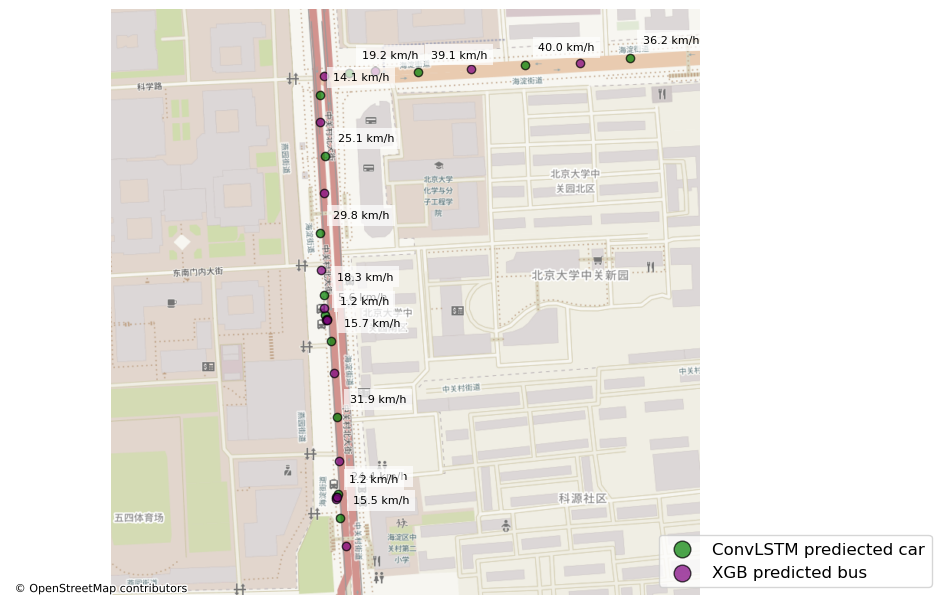

In [ ]:
# Convert coordinates
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
new_df['x'], new_df['y'] = transformer.transform(
    new_df['lon'].values,
    new_df['lat'].values
)

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

segment_to_plot = 7650
color1 = 'green'  
color2 = 'purple'  
label1 = f'ConvLSTM prediected car'
label2 = f'XGB predicted bus'

# Filter data for the specific segment
df_segment = new_df[new_df['new_segment'] == segment_to_plot].copy() 

# Check if there's data to plot for this segment
if not df_segment.empty:
    even_points = df_segment.iloc[::2] 
    ax.scatter(
        even_points['x'],
        even_points['y'],
        color=color1,
        label=label1,
        alpha=0.7,
        edgecolor='k',
        zorder=2
    )

    # Plot odd-indexed points
    odd_points = df_segment.iloc[1::2] 
    ax.scatter(
        odd_points['x'],
        odd_points['y'],
        color=color2,
        label=label2,
        alpha=0.7,
        edgecolor='k',
        zorder=2
    )
else:
    print(f"No data found for segment {segment_to_plot}")

x_offset = 20
y_offset = 20
# This loop adds labels only to the points plotted first (even indices)
for i in range(0, len(df_segment), 2):
    # Ensure index exists before trying iloc
    if i < len(df_segment):
        row = df_segment.iloc[i]
        label_x = row['x'] + x_offset
        label_y = row['y'] + y_offset

        ax.text(
            label_x,
            label_y,
            f"{row['speed']*250:.1f} km/h", # Assuming speed conversion is correct
            fontsize=8,
            ha='left',
            va='bottom',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
            zorder=3
        )

# Add basemap
ctx.add_basemap(
    ax,
    url="https://tile.openstreetmap.org/{z}/{x}/{y}.png",
    attribution="© OpenStreetMap contributors",
    zorder=1
)

# Customize plot bounds (use df_segment if you only want bounds around plotted segment)
if not df_segment.empty:
    x_min, x_max = df_segment['x'].min(), df_segment['x'].max()
    y_min, y_max = df_segment['y'].min(), df_segment['y'].max()

    x_pad = (x_max - x_min) * 1 # Adjusted padding slightly
    y_pad = (y_max - y_min) * 0.1

    ax.set_xlim(x_min - x_pad, x_max + x_pad)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)
else:
     # Optional: Set default bounds or handle empty data case
     print("Cannot set bounds: No data plotted.")


# Final adjustments
ax.set_aspect('equal')
ax.set_axis_off()

# Update legend - it will now show two entries if both even/odd points exist
plt.legend(
    #title='Trajectory segments', # Consider removing or changing title
    loc='lower right',
    fontsize=12,
    title_fontsize=14,
    markerscale=2,
    frameon=True,
    framealpha=0.8
)

os.makedirs("Graphs", exist_ok=True)

plt.savefig("Graphs/single_predicted_trajectory_alternating_color.png", dpi=500, bbox_inches="tight")
plt.show()

Thresholding! Only use predictions where the model was certain

In [217]:
threshold = 0.80
updated_df = updated_df[updated_df['prediction_certainty'] >= threshold]

Endode labels

In [ ]:
updated_df['label'] = label_encoder.fit_transform(updated_df['predicted_class_label'])

In [219]:
unique_segments_per_label = updated_df.groupby('predicted_class_label')['new_segment'].nunique()
print(unique_segments_per_label)

predicted_class_label
bike      3452
bus       1988
car      60984
train    28154
walk      3118
Name: new_segment, dtype: int64


In [220]:
unique_segments_per_label = df.groupby('label')['segment'].nunique()
print(unique_segments_per_label)

label
0    1899
1    2633
2    2110
3    1247
4    6012
Name: segment, dtype: int64


In [76]:
y_train

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

First to rolling window on x_train!

In [215]:
# Create rolling windows
X_train, y_train = create_rolling_windows(X_train, y_train, window_size, step_size)

# Verify shape
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (27763, 200, 6)
Shape of y_train: (27763, 5)


In [ ]:
class_counts = None # Initialize

if isinstance(y_train, np.ndarray) and y_train.ndim == 2:

    decoded_labels = np.argmax(y_train, axis=1)
    print(f"Decoded class labels: {decoded_labels}") # e.g., [0 1 1 2 0 1]

    label_series = pd.Series(decoded_labels)
    class_counts = label_series.value_counts().sort_index() # sort_index() orders by class label (0, 1, 2...)

    print("\nCounts per class (using Pandas value_counts):")
    print(class_counts)


elif isinstance(y_train, list):
     try:
        print("Attempting to process as a list of lists...")
        # Decode
        decoded_labels = [row.index(1) for row in y_train] # Find index of '1' in each sublist
        print(f"Decoded class labels: {decoded_labels}")

        # Count (using Pandas value_counts)
        label_series = pd.Series(decoded_labels)
        class_counts = label_series.value_counts().sort_index()
        print("\nCounts per class (using Pandas value_counts):")
        print(class_counts)

     except ValueError:
         print("Error: Could not find index of '1' in every row. Check if input is valid one-hot encoded list of lists.")
     except Exception as e:
         print(f"An error occurred processing the list: {e}")
else:
    print(f"Error: Expected y_train to be a 2D NumPy array or list of lists for OHE decoding, but got {type(y_train)}.")


if class_counts is not None:
    print("\n--- Summary ---")
    if isinstance(class_counts, pd.Series):
         for class_label, count in class_counts.items():
              print(f"Class {class_label}: {count} occurrences")


Decoded class labels: [0 0 0 ... 0 0 0]

Counts per class (using Pandas value_counts):
0    4022
1    6966
2    4334
3    4982
4    7459
Name: count, dtype: int64

--- Summary ---
Class 0: 4022 occurrences
Class 1: 6966 occurrences
Class 2: 4334 occurrences
Class 3: 4982 occurrences
Class 4: 7459 occurrences


Set how much of the pseudo-labeled data should be used

In [ ]:
targets = {
    0: 3452,
    1: 500,
    2: 3000,
    3: 2900,
    4: 0
}

In [222]:
# Group segments by their pseudo_label and count data points per segment
segment_groups = (
    updated_df.groupby(['label', 'segment'])
    .size()
    .reset_index(name='count')
)

In [ ]:

segment_groups = pd.DataFrame(segment_groups)

segments_to_keep = []

print("Selecting segments based on target *number of segments* per label (no specific order)...")

# Iterate through each label
for label, target_segment_count in targets.items():

    # Get segments belonging to the current label
    # Using .copy() avoids SettingWithCopyWarning if you modify label_segments later
    label_segments = segment_groups[segment_groups['label'] == label].copy()

    # Skip if no segments exist for this label
    if label_segments.empty:
        print(f"Label {label}: No segments found. Skipping.")
        continue

    # Keep track of how many segments we've selected for this label
    num_selected_so_far = 0
    selected_segments_for_label = []
    total_data_points_in_selection = 0 # Optional: Track total points for info

    # Iterate through the segments for this label (in their existing order within the group)
    for _, row in label_segments.iterrows():
        # Check if we have already reached the target number of segments
        if num_selected_so_far >= target_segment_count:
            break  # Stop selecting more segments for this label

        # Select the current segment (add its ID to the list)
        selected_segments_for_label.append(row['segment'])
        num_selected_so_far += 1
        total_data_points_in_selection += row['count'] # Optional

    # Add the selected segment IDs for this label to the overall list
    segments_to_keep.extend(selected_segments_for_label)

    # The order of IDs in selected_segments_for_label now depends on the original DataFrame order
    print(f"Label {label}: Target segments={target_segment_count}. "
          f"Selected {num_selected_so_far} segments "
          f"(IDs: {selected_segments_for_label}). "
          f"Total data points: {total_data_points_in_selection}") # Optional info


print(f"\nFinal list of segment IDs to keep across all labels: {segments_to_keep}")


Selecting segments based on target *number of segments* per label (no specific order)...
Label 0: Target segments=3452. Selected 3390 segments (IDs: [15.91, 39.0, 53.0, 63.0, 141.0, 224.0, 238.0, 257.0, 258.0, 259.0, 271.1, 316.0, 549.0, 603.0, 609.0, 839.11, 857.0, 857.1, 859.0, 859.1, 869.4, 876.0, 885.0, 888.0, 899.0, 907.0, 907.1, 907.2, 918.0, 919.0, 931.0, 932.0, 933.1, 933.2, 934.0, 938.0, 949.0, 950.0, 952.0, 952.1, 954.0, 964.0, 966.0, 966.2, 973.0, 973.1, 974.0, 980.0, 980.1, 980.2, 981.0, 983.0, 988.0, 988.1, 988.2, 988.3, 988.4, 994.1, 994.3, 994.4, 994.5, 994.6, 994.7, 994.8, 994.9, 997.0, 999.0, 999.1, 1010.0, 1024.0, 1038.2, 1039.0, 1044.1, 1045.0, 1045.1, 1049.4, 1052.0, 1052.1, 1058.0, 1074.0, 1074.1, 1074.3, 1074.4, 1074.5, 1074.6, 1074.7, 1074.8, 1089.0, 1089.1, 1090.0, 1096.0, 1118.1, 1118.2, 1118.3, 1118.5, 1118.6, 1124.0, 1133.0, 1139.0, 1141.0, 1142.0, 1142.1, 1142.3, 1142.4, 1148.0, 1157.0, 1157.1, 1157.2, 1171.0, 1174.1, 1174.2, 1174.3, 1179.0, 1189.0, 1190.0, 

In [42]:
segment_groups

,label,segment,count
0,0,15.91,84
1,0,63.00,193
2,0,141.00,87
3,0,238.00,132
4,0,257.00,127
...,...,...,...
80838,4,31922.60,182
80839,4,31939.00,171
80840,4,31985.10,136
80841,4,32057.10,108


In [224]:
# Filter unlabeled_df to keep only selected segments
filtered_unlabeled_df = updated_df[updated_df['segment'].isin(segments_to_keep)]

# Verify final counts
final_counts = filtered_unlabeled_df['label'].value_counts().to_dict()
print("Final data points per label:")
print(final_counts)

Final data points per label:
{0: 513542, 3: 325376, 2: 295245, 1: 82928, 4: 1696}


In [225]:
segments_per_label = filtered_unlabeled_df.groupby('label')['segment'].nunique()
print(segments_per_label)

label
0    3390
1     501
2    3675
3    2523
4      12
Name: segment, dtype: int64


Create new sequences

In [226]:
X_sequences_unlabeled = []
y_sequences_unlabeled = []

for _, group in filtered_unlabeled_df.groupby('segment'):
    X_sequences_unlabeled.append(group[time_series_features].values)  # Raw sequences
    y_sequences_unlabeled.append(group['label'].iloc[0])  # Assign one label per segment

In [227]:
# Convert labels to one-hot encoding
y_sequences_unlabeled = to_categorical(y_sequences_unlabeled)
#X_sequences.shape()
y_sequences_unlabeled

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [228]:
X_train_unlabeled, X_test2, y_train_unlabeled, y_test_2 = train_test_split(X_sequences_unlabeled, y_sequences_unlabeled, test_size=0.001, random_state=19)

In [229]:
# Set parameters
window_size = 200  # Length of each segment
step_size = 200  # Step between windows

# Create rolling windows
X_train_unlabeled, y_train_unlabeled = create_rolling_windows(X_train_unlabeled, y_train_unlabeled, window_size, step_size)

# Verify shape
print("Shape of X_train (unlabeled):", X_train_unlabeled.shape)
print("Shape of y_train (unlabeled):", y_train_unlabeled.shape)

Shape of X_train (unlabeled): (8675, 200, 6)
Shape of y_train (unlabeled): (8675, 5)


In [230]:
# Set parameters
window_size = 200  # Length of each segment
step_size = 50  # Step between windows

# Create rolling windows
X_train, y_train = create_rolling_windows(X_train, y_train, window_size, step_size)

# Verify shape
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (27763, 200, 6)
Shape of y_train: (27763, 5)


Merge!

In [231]:
X_train_merged = np.concatenate((X_train, X_train_unlabeled), axis=0)
print("Shape of X_train_merged:", X_train_merged.shape)

Shape of X_train_merged: (36438, 200, 6)


In [232]:
y_train_merged = np.concatenate((y_train, y_train_unlabeled), axis=0)
print("Shape of y_train_merged:", y_train_merged.shape)

Shape of y_train_merged: (36438, 5)


In [ ]:
class_counts = None # Initialize


if isinstance(y_train_merged, np.ndarray) and y_train.ndim == 2:


    decoded_labels = np.argmax(y_train_merged, axis=1)
    print(f"Decoded class labels: {decoded_labels}") # e.g., [0 1 1 2 0 1]

    # Count Occurrences of Each Decoded Label
    label_series = pd.Series(decoded_labels)
    class_counts = label_series.value_counts().sort_index() # sort_index() orders by class label (0, 1, 2...)

    print("\nCounts per class (using Pandas value_counts):")
    print(class_counts)


elif isinstance(y_train, list):
     try:
        print("Attempting to process as a list of lists...")
        # Decode
        decoded_labels = [row.index(1) for row in y_train] # Find index of '1' in each sublist
        print(f"Decoded class labels: {decoded_labels}")

        # Count (using Pandas value_counts)
        label_series = pd.Series(decoded_labels)
        class_counts = label_series.value_counts().sort_index()
        print("\nCounts per class (using Pandas value_counts):")
        print(class_counts)

     except ValueError:
         print("Error: Could not find index of '1' in every row. Check if input is valid one-hot encoded list of lists.")
     except Exception as e:
         print(f"An error occurred processing the list: {e}")
else:
    print(f"Error: Expected y_train to be a 2D NumPy array or list of lists for OHE decoding, but got {type(y_train)}.")


# Display final summary if counts were calculated
if class_counts is not None:
    print("\n--- Summary ---")
    if isinstance(class_counts, pd.Series):
         for class_label, count in class_counts.items():
              print(f"Class {class_label}: {count} occurrences")
    # Add similar loop if using the dict from np.unique or Counter if needed

Decoded class labels: [0 0 0 ... 2 2 2]

Counts per class (using Pandas value_counts):
0    7273
1    7387
2    7358
3    6960
4    7460
Name: count, dtype: int64

--- Summary ---
Class 0: 7273 occurrences
Class 1: 7387 occurrences
Class 2: 7358 occurrences
Class 3: 6960 occurrences
Class 4: 7460 occurrences


New Validation set

In [234]:
X_train_merged, X_val_merged, y_train_merged, y_val_merged = train_test_split(X_train_merged, y_train_merged, test_size=0.1, random_state=19)

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


Train again

In [235]:
input_shape = (X_train_merged.shape[1], X_train_merged.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]

In [240]:
model2 = create_lstm_model(input_shape, num_classes)

In [241]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history_merged = model2.fit(X_train_merged, y_train_merged, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val_merged, y_val_merged), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 163s 158ms/step - accuracy: 0.2740 - loss: 1.5465 - val_accuracy: 0.4042 - val_loss: 1.4838 - learning_rate: 0.0010
Epoch 2/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 164s 160ms/step - accuracy: 0.4282 - loss: 1.3257 - val_accuracy: 0.6556 - val_loss: 0.9292 - learning_rate: 0.0010
Epoch 3/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 161s 157ms/step - accuracy: 0.4115 - loss: 1.3519 - val_accuracy: 0.6748 - val_loss: 0.8911 - learning_rate: 0.0010
Epoch 4/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 163s 159ms/step - accuracy: 0.5909 - loss: 1.0436 - val_accuracy: 0.7662 - val_loss: 0.6962 - learning_rate: 0.0010
Epoch 5/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 164s 160ms/step - accuracy: 0.7413 - loss: 0.7616 - val_accuracy: 0.7585 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 6/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 163s 159ms/step - accuracy: 0.7669 - loss: 0.6995 - val_accuracy: 0.7903 - val_loss: 0.6408 - learning_rate: 0.0010
Epoch 7/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 167s 163ms

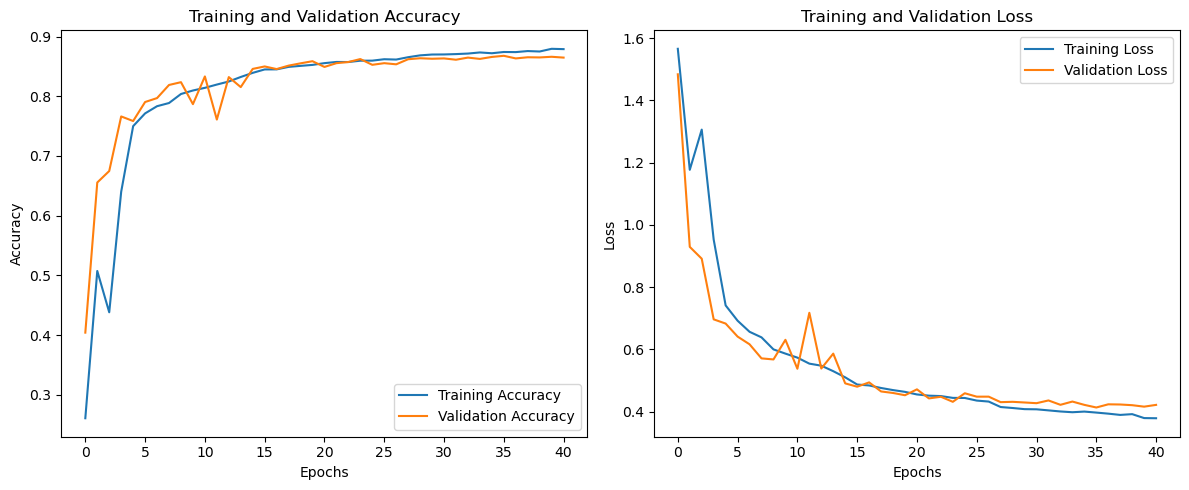

235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.925     0.870     0.897      1022
         bus      0.871     0.737     0.799      1818
         car      0.681     0.752     0.715      1026
       train      0.956     0.911     0.933      1838
        walk      0.843     0.993     0.912      1800

    accuracy                          0.861      7504
   macro avg      0.855     0.853     0.851      7504
weighted avg      0.867     0.861     0.861      7504



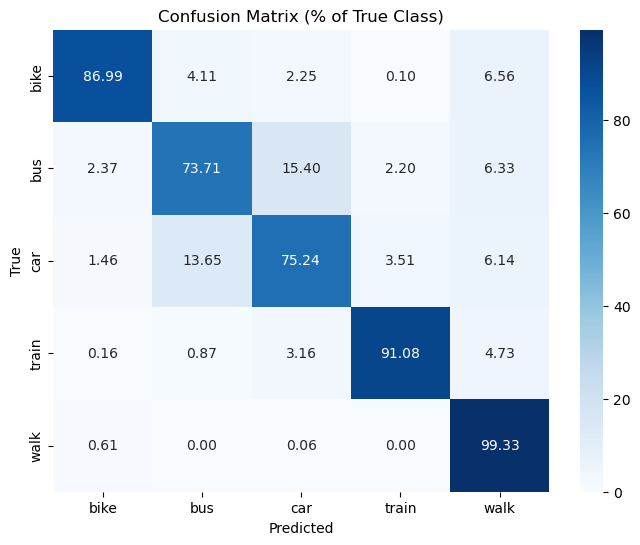

In [242]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_merged.history['accuracy'], label='Training Accuracy')
plt.plot(history_merged.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_merged.history['loss'], label='Training Loss')
plt.plot(history_merged.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_,digits=3  # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()